In [59]:
import numpy as np
import pandas as pd
import imp
from sklearn import metrics
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error
import torch.nn as nn
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
import torch
import torchvision
import graphviz
from sklearn.tree import export_graphviz
import numpy as np
import timeit
from sklearn import svm
import struct
import os
import gzip
import time
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号
from sklearn.preprocessing import StandardScaler as SS
import torchvision
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from torch import cuda
#torch.cuda.is_available = lambda : False#测试CPU训练

In [60]:
torch.cuda.is_available()

False

In [3]:
print(torch.cuda.is_available())

True


In [46]:
#读取文件以及处理所用函数部分
img_size = 784 #(28*28)
def load_img(file_name):#读取文件
    file_path =  file_name
    
    print("读取文件 " + file_name)    
    with gzip.open(file_path, 'rb') as f:
            data = np.frombuffer(f.read(), np.uint8, offset=16)
    data = data.reshape(-1, img_size)#共image_siza=28*28列，-1为自适应行数
    print("Done")
    
    return data
def load_label(file_name):#读取label
    file_path =file_name
    print("读取文件 " + file_name )
    with gzip.open(file_path, 'rb') as f:
            labels = np.frombuffer(f.read(), np.uint8, offset=8)
    print("Done")
    
    return labels
class MyDataSet(torch.utils.data.Dataset):#自定义dataset类
    def __init__(self, imgs, labels):
        self._data = imgs
        self._label = labels
    def __getitem__(self,idx):
        img = torch.Tensor(self._data[idx]).view(1,28,28)#将标准化后的数据规范为torch类型的灰度矩阵
        label = self._label[idx]
        return img,label
    def __len__(self):
        return len(self._data)
#SVC分类器部分与所用函数部分
def classify(c=0.5,typename='linear'):#构建一个SVC分类器
    clf=svm.SVC(C=c,
               kernel=typename,
               decision_function_shape='ovr')
    return clf
def svctrain(clf,feature,target):#开始训练
    T1 = time.perf_counter()
    clf.fit(feature,target.ravel())#扁平化
    T2 =time.perf_counter()
    print('训练时间:%s毫秒' % ((T2 - T1)*1000))
def print_accuracy(clf,x_train,y_train,x_test,y_test):#进行训练集与测试机的准确率
    T1 = time.perf_counter()
    pretrain=clf.predict(x_train)#训练集预测
    pretest=clf.predict(x_test)
    T2 =time.perf_counter()
    print('预测时间:%s毫秒' % ((T2 - T1)*1000))
    print('训练集评估')
    print(len(y_train),len(pretrain))
    print(classification_report(y_train, pretrain,digits=4))
    print('测试集评估')
    print(classification_report(y_test, pretest,digits=4))
# 模型评估
def Myshuffle(data,label,num):#随机抽选函数，从数据集与标签随机抽选部分出来用于训练
    print(data.shape,label.shape)
    trd=np.concatenate([data,label.reshape(len(label),1)],axis=1)
    np.random.shuffle(trd)
    nowtraindata=np.array(trd[0:num])
    traindata=nowtraindata[:,0:-1]
    labeldata=nowtraindata[:,-1]
    print(traindata.shape,labeldata.shape)
    return traindata,labeldata
#神经网络定义与所用函数部分
class Neuro_net(nn.Module):
    """定义神经网络"""
    def __init__(self):
        super(Neuro_net, self).__init__()   # 继承__init__功能
        self.conv1=nn.Conv2d(1,10,kernel_size=5)#第一个2d卷积层 
        self.conv2=nn.Conv2d(10,20,kernel_size=5)#第二个2d卷积层
        self.drop=nn.Dropout2d(p=p_drop)#2ddropout层
        self.fullhidden1=nn.Linear(320,50)#全连接层1
        self.fullhidden2=nn.Linear(50,10)#输出层

    def forward(self, x):#前向传播
        x=F.max_pool2d(self.conv1(x),2)#第一个2d卷积层，这一步后图像大小为24*24*10通道*样本数量为一个patch64个
                                       #再经过一个池化操作，使用滑动窗口为2的，(24-2)/2+1=12将图片池化为12*12*10*64个
        x=F.relu(x)#用relu激活函数 
        x=F.max_pool2d(self.drop(self.conv2(x)),2)#第二个2d卷积层，这一步后图像大小为8*8*20通道*样本数量64
                                                  #在经过一个池化操作，使用滑动窗口为2的，(8-2)/2+1=4将图片池化为4*4*20通道*64个
        x=F.relu(x)#relu激活函数
        x=x.view(-1,320)#reshape一下 每个样本现在大小为20通道*4*4=320
        x=self.fullhidden1(x)#全连接层
        x=F.relu(x)#激活函数
        x=F.dropout(x,training=self.training)#dropout层
        x=self.fullhidden2(x)#输出层
        return F.log_softmax(x,dim=-2)#g归一化
def train(epoch):#记录一下这是第几轮训练，训练所用函数
    net.train()#切换到训练模式下
    T1 = time.perf_counter()
    for nowstep, (data, target) in enumerate(train_loader):#使用train_loader的迭代的方法进行训练
        optimizer.zero_grad()#初始化优化器
        if torch.cuda.is_available():
            data = data.cuda()
            target = target.cuda()
        output = net(data)#前向传播得到结果
        loss = F.nll_loss(output, target)#使用nll作为损失函数计算损失
        if torch.cuda.is_available():	
            loss = loss.cuda()
        loss.backward()#后向传播计算梯度
        optimizer.step()#使用优化器更新模型中的参数
        #print(loss.item())
        if nowstep % log_interval == 0:#每log_interval次输出一次
            print('当前训练轮数: {} [ 当前轮次训练进度 {}/{} ({:.2f}%)]\tLoss为: {:.6f}'.format(
                epoch, nowstep * len(data), len(train_loader.dataset),
                100. * nowstep / len(train_loader), loss.item()))#输出当前训练进度
            train_losses.append(loss.item())#记录训练过程中loss的下降过程
            train_counter.append((nowstep*64) + ((epoch-1)*len(train_loader.dataset)))#每一个patch记录一个值用于画图
            torch.save(net.state_dict(), './model.pth')#及时的保存模型参数
            torch.save(optimizer.state_dict(), './optimizer.pth')#及时的保存当前优化器状态
    T2 =time.perf_counter()
    print('本轮训练时间:%s毫秒' % ((T2 - T1)*1000))            
def test(epoch):#测试模型,当前为第几轮测试
    net.eval()#切换到eval模式，固定BN和DropOut层
    test_loss = 0                      
    correctlist=[]
    prelist=[]
    with torch.no_grad():#将设置tensor的requires_grad都自动设置为False，反向传播不会求导以节省时间
        for data, target in test_loader:#对于测试集的每一条数据
            if torch.cuda.is_available():
                data = data.cuda()
                target = target.cuda()
            output = net(data)#得到输出结果
            loss = F.nll_loss(output, target,size_average=False)#计算测试集loss值
            if torch.cuda.is_available():	
                loss = loss.cuda()
            test_loss+=loss.item()

            pred = output.data.max(1, keepdim=True)[1]#得到预测值
            if torch.cuda.is_available():
                prelist.extend((pred.cpu().numpy()))#得到预测标签
            else:
                prelist.extend((pred.numpy()))#得到预测标签
            if torch.cuda.is_available():
                correctlist.extend((target.data.view_as(pred).cpu().numpy()))#正确标签
            else:
                correctlist.extend((target.data.view_as(pred).numpy()))#正确标签
        test_loss /= len(test_loader.dataset)#计算平的testloss
    test_losses.append(test_loss)#添加进图中进行评测
    test_counter.append(epoch*len(train_loader.dataset))#这个点的横坐标也添加进去

    print('当前模型的测试集评估结果为：')
    print(classification_report(prelist,correctlist,digits=4))#输出预测报告如何
    print('Loss值为{:.4f}'.format(test_loss))
def pred(data_loader,mynet):#使用模型进行预测
    mynet.eval()
    correctlist=[]
    prelist=[]
    T1 = time.perf_counter()
    with torch.no_grad():#将设置tensor的requires_grad都自动设置为False，反向传播不会求导以节省时间
        for data, target in data_loader:#对于测试集的每一条数据
            if torch.cuda.is_available():
                data = data.cuda()
                target = target.cuda()
            output = net(data)#得到输出结果
            pred = output.data.max(1, keepdim=True)[1]#得到预测值
            if torch.cuda.is_available():
                prelist.extend((pred.cpu().numpy()))#得到预测标签
            else:
                prelist.extend((pred.numpy()))#得到预测标签
            if torch.cuda.is_available():
                correctlist.extend((target.data.view_as(pred).cpu().numpy()))#正确标签
            else:
                correctlist.extend((target.data.view_as(pred).numpy()))#正确标签
    T2 =time.perf_counter()
    print('预测时间:%s毫秒' % ((T2 - T1)*1000))     
    print('当前模型的预测评估结果为：')
    print(classification_report(prelist,correctlist,digits=4))#输出预测报告如何

In [61]:
#设置参数
n_epochs = 3 #循环训练集的次数
p_drop=0.5#dropout丢弃的百分比
batch_size_train = 64#一次训练抓取的数据量
batch_size_test = 1000#一次测试抓取的数据量
learning_rate = 0.001#学习率
learning_rate_delay=0.2#学习率衰减
weightdecay=0.0#L2乘法
momentum = 0.5 #SGD所用超参数
log_interval = 10#每训练多少次输出一次
random_seed = 1#随机数种子


In [32]:

#数据加载与预处理模块
#读取.gz文件
train_data=load_img('train-images-idx3-ubyte.gz')
train_label=load_label('train-labels-idx1-ubyte.gz')
test_data=load_img('t10k-images-idx3-ubyte.gz')
test_label=load_label('t10k-labels-idx1-ubyte.gz')
#标准化
ss=SS()#进行标准化
zsocre=ss.fit(train_data)#按照原始训练集生成规则，训练的均值和标准差
ss_train_data=zsocre.transform(train_data)#应用测试集
ss_test_data=zsocre.transform(test_data)#应用测试集
#转换为dataset
train_dataset=MyDataSet(ss_train_data,train_label)
test_dataset=MyDataSet(ss_test_data,test_label)
#制作dataloader
train_loader=torch.utils.data.DataLoader(train_dataset,batch_size=batch_size_train, shuffle=True)#使用Dataloader读取样本数据和测试数据
test_loader=torch.utils.data.DataLoader(test_dataset,batch_size=batch_size_train, shuffle=True)#分批训练


读取文件 train-images-idx3-ubyte.gz
Done
读取文件 train-labels-idx1-ubyte.gz
Done
读取文件 t10k-images-idx3-ubyte.gz
Done
读取文件 t10k-labels-idx1-ubyte.gz
Done


tensor([4, 8, 6, 3, 6, 7, 5, 3, 5, 6, 2, 2, 2, 1, 9, 7, 6, 1, 5, 3, 8, 8, 0, 9,
        8, 1, 3, 9, 1, 1, 1, 4, 9, 1, 0, 1, 3, 7, 3, 2, 2, 1, 5, 2, 2, 2, 2, 2,
        1, 2, 9, 0, 3, 0, 2, 7, 7, 3, 8, 6, 9, 3, 9, 1], dtype=torch.uint8)
torch.Size([64, 1, 28, 28])


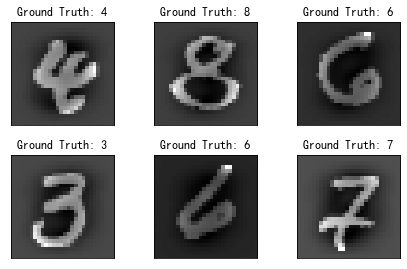

当前训练轮数: 1 [ 当前轮次训练进度 0/60000 (0.00%)]	Loss为: 4.201187
当前训练轮数: 1 [ 当前轮次训练进度 640/60000 (1.07%)]	Loss为: 4.137649
当前训练轮数: 1 [ 当前轮次训练进度 1280/60000 (2.13%)]	Loss为: 4.060502
当前训练轮数: 1 [ 当前轮次训练进度 1920/60000 (3.20%)]	Loss为: 3.787884
当前训练轮数: 1 [ 当前轮次训练进度 2560/60000 (4.26%)]	Loss为: 3.730673
当前训练轮数: 1 [ 当前轮次训练进度 3200/60000 (5.33%)]	Loss为: 3.419785
当前训练轮数: 1 [ 当前轮次训练进度 3840/60000 (6.40%)]	Loss为: 3.381813
当前训练轮数: 1 [ 当前轮次训练进度 4480/60000 (7.46%)]	Loss为: 3.345403
当前训练轮数: 1 [ 当前轮次训练进度 5120/60000 (8.53%)]	Loss为: 3.187230
当前训练轮数: 1 [ 当前轮次训练进度 5760/60000 (9.59%)]	Loss为: 3.029466
当前训练轮数: 1 [ 当前轮次训练进度 6400/60000 (10.66%)]	Loss为: 3.275100
当前训练轮数: 1 [ 当前轮次训练进度 7040/60000 (11.73%)]	Loss为: 3.179549
当前训练轮数: 1 [ 当前轮次训练进度 7680/60000 (12.79%)]	Loss为: 3.020936
当前训练轮数: 1 [ 当前轮次训练进度 8320/60000 (13.86%)]	Loss为: 3.151371
当前训练轮数: 1 [ 当前轮次训练进度 8960/60000 (14.93%)]	Loss为: 2.998819
当前训练轮数: 1 [ 当前轮次训练进度 9600/60000 (15.99%)]	Loss为: 2.908433
当前训练轮数: 1 [ 当前轮次训练进度 10240/60000 (17.06%)]	Loss为: 2.927741
当前训练轮数: 1 [ 当前轮次训练进度 10880/

D:\Anacoda\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


当前模型的测试集评估结果为：
              precision    recall  f1-score   support

           0     0.9878    0.9778    0.9827       990
           1     0.9841    0.9841    0.9841      1135
           2     0.9680    0.9523    0.9601      1049
           3     0.9673    0.9750    0.9712      1002
           4     0.9593    0.9652    0.9622       976
           5     0.9787    0.9572    0.9678       912
           6     0.9823    0.9711    0.9766       969
           7     0.9484    0.9625    0.9554      1013
           8     0.9384    0.9601    0.9491       952
           9     0.9395    0.9461    0.9428      1002

    accuracy                         0.9654     10000
   macro avg     0.9654    0.9651    0.9652     10000
weighted avg     0.9656    0.9654    0.9654     10000

Loss值为2.0556
当前训练轮数: 2 [ 当前轮次训练进度 0/60000 (0.00%)]	Loss为: 2.254375
当前训练轮数: 2 [ 当前轮次训练进度 640/60000 (1.07%)]	Loss为: 2.414514
当前训练轮数: 2 [ 当前轮次训练进度 1280/60000 (2.13%)]	Loss为: 2.178247
当前训练轮数: 2 [ 当前轮次训练进度 1920/60000 (3.20%)]	Loss为

D:\Anacoda\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


当前模型的测试集评估结果为：
              precision    recall  f1-score   support

           0     0.9888    0.9758    0.9823       993
           1     0.9921    0.9851    0.9886      1143
           2     0.9767    0.9637    0.9702      1046
           3     0.9713    0.9830    0.9771       998
           4     0.9796    0.9591    0.9693      1003
           5     0.9832    0.9712    0.9772       903
           6     0.9656    0.9861    0.9757       938
           7     0.9553    0.9704    0.9627      1012
           8     0.9589    0.9780    0.9684       955
           9     0.9564    0.9564    0.9564      1009

    accuracy                         0.9729     10000
   macro avg     0.9728    0.9729    0.9728     10000
weighted avg     0.9730    0.9729    0.9729     10000

Loss值为2.0146
当前训练轮数: 3 [ 当前轮次训练进度 0/60000 (0.00%)]	Loss为: 2.314791
当前训练轮数: 3 [ 当前轮次训练进度 640/60000 (1.07%)]	Loss为: 2.175179
当前训练轮数: 3 [ 当前轮次训练进度 1280/60000 (2.13%)]	Loss为: 2.165149
当前训练轮数: 3 [ 当前轮次训练进度 1920/60000 (3.20%)]	Loss为

D:\Anacoda\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


当前模型的测试集评估结果为：
              precision    recall  f1-score   support

           0     0.9888    0.9848    0.9868       984
           1     0.9912    0.9877    0.9894      1139
           2     0.9884    0.9641    0.9761      1058
           3     0.9832    0.9754    0.9793      1018
           4     0.9695    0.9734    0.9714       978
           5     0.9843    0.9691    0.9766       906
           6     0.9781    0.9832    0.9806       953
           7     0.9591    0.9762    0.9676      1010
           8     0.9620    0.9853    0.9735       951
           9     0.9554    0.9611    0.9583      1003

    accuracy                         0.9761     10000
   macro avg     0.9760    0.9760    0.9760     10000
weighted avg     0.9762    0.9761    0.9761     10000

Loss值为1.9996


Text(0, 0.5, 'loss值')

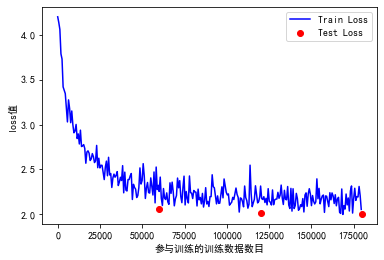

In [62]:
#训练模块
net = Neuro_net()#初始化神经网络
if torch.cuda.is_available():
    net=net.cuda()
#optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate,momentum=momentum)#SGD优化器
optimizer=torch.optim.Adam(net.parameters(), lr=learning_rate,weight_decay =weightdecay)#ADAM优化器
#optimizer=torch.optim.RMSprop(net.parameters(), lr=learning_rate)#RMSprop优化器
#初始
train_losses = []
train_counter = []
test_losses = []
test_counter = []#初始化用于绘图的各矩阵


for epoch in range(1, n_epochs + 1):#训练epoch轮
    train(epoch)
    test(epoch)
fig = plt.figure()#绘图
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('参与训练的训练数据数目')
plt.ylabel('loss值')

[2.062893170166016,
 2.012546996116638,
 1.9973913480758667,
 1.986419263935089,
 1.9849391593933106]

当前训练轮数: 6 [ 当前轮次训练进度 0/60000 (0.00%)]	Loss为: 2.059389
当前训练轮数: 6 [ 当前轮次训练进度 640/60000 (1.07%)]	Loss为: 2.097760
当前训练轮数: 6 [ 当前轮次训练进度 1280/60000 (2.13%)]	Loss为: 2.115132
当前训练轮数: 6 [ 当前轮次训练进度 1920/60000 (3.20%)]	Loss为: 2.190043
当前训练轮数: 6 [ 当前轮次训练进度 2560/60000 (4.26%)]	Loss为: 2.169718
当前训练轮数: 6 [ 当前轮次训练进度 3200/60000 (5.33%)]	Loss为: 2.070814
当前训练轮数: 6 [ 当前轮次训练进度 3840/60000 (6.40%)]	Loss为: 2.082870
当前训练轮数: 6 [ 当前轮次训练进度 4480/60000 (7.46%)]	Loss为: 2.021296
当前训练轮数: 6 [ 当前轮次训练进度 5120/60000 (8.53%)]	Loss为: 2.299728
当前训练轮数: 6 [ 当前轮次训练进度 5760/60000 (9.59%)]	Loss为: 2.098436
当前训练轮数: 6 [ 当前轮次训练进度 6400/60000 (10.66%)]	Loss为: 1.996093
当前训练轮数: 6 [ 当前轮次训练进度 7040/60000 (11.73%)]	Loss为: 2.174827
当前训练轮数: 6 [ 当前轮次训练进度 7680/60000 (12.79%)]	Loss为: 2.098523
当前训练轮数: 6 [ 当前轮次训练进度 8320/60000 (13.86%)]	Loss为: 2.075861
当前训练轮数: 6 [ 当前轮次训练进度 8960/60000 (14.93%)]	Loss为: 2.022862
当前训练轮数: 6 [ 当前轮次训练进度 9600/60000 (15.99%)]	Loss为: 2.121410
当前训练轮数: 6 [ 当前轮次训练进度 10240/60000 (17.06%)]	Loss为: 2.303966
当前训练轮数: 6 [ 当前轮次训练进度 10880/

D:\Anacoda\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


当前模型的测试集评估结果为：
              precision    recall  f1-score   support

           0     0.9939    0.9838    0.9888       990
           1     0.9912    0.9929    0.9921      1133
           2     0.9903    0.9855    0.9879      1037
           3     0.9792    0.9851    0.9821      1004
           4     0.9847    0.9797    0.9822       987
           5     0.9798    0.9765    0.9782       895
           6     0.9823    0.9833    0.9828       957
           7     0.9835    0.9825    0.9830      1029
           8     0.9702    0.9834    0.9767       961
           9     0.9722    0.9742    0.9732      1007

    accuracy                         0.9829     10000
   macro avg     0.9827    0.9827    0.9827     10000
weighted avg     0.9829    0.9829    0.9829     10000

Loss值为1.9765
当前训练轮数: 7 [ 当前轮次训练进度 0/60000 (0.00%)]	Loss为: 2.065941
当前训练轮数: 7 [ 当前轮次训练进度 640/60000 (1.07%)]	Loss为: 2.113614
当前训练轮数: 7 [ 当前轮次训练进度 1280/60000 (2.13%)]	Loss为: 2.061671
当前训练轮数: 7 [ 当前轮次训练进度 1920/60000 (3.20%)]	Loss为

D:\Anacoda\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


当前模型的测试集评估结果为：
              precision    recall  f1-score   support

           0     0.9939    0.9858    0.9898       988
           1     0.9938    0.9912    0.9925      1138
           2     0.9864    0.9845    0.9855      1034
           3     0.9851    0.9822    0.9837      1013
           4     0.9837    0.9827    0.9832       983
           5     0.9832    0.9854    0.9843       890
           6     0.9843    0.9885    0.9864       954
           7     0.9854    0.9740    0.9797      1040
           8     0.9743    0.9814    0.9778       967
           9     0.9653    0.9809    0.9730       993

    accuracy                         0.9837     10000
   macro avg     0.9836    0.9837    0.9836     10000
weighted avg     0.9838    0.9837    0.9837     10000

Loss值为1.9723
当前训练轮数: 8 [ 当前轮次训练进度 0/60000 (0.00%)]	Loss为: 2.178712
当前训练轮数: 8 [ 当前轮次训练进度 640/60000 (1.07%)]	Loss为: 2.067454
当前训练轮数: 8 [ 当前轮次训练进度 1280/60000 (2.13%)]	Loss为: 2.150811
当前训练轮数: 8 [ 当前轮次训练进度 1920/60000 (3.20%)]	Loss为

D:\Anacoda\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


当前模型的测试集评估结果为：
              precision    recall  f1-score   support

           0     0.9959    0.9770    0.9864       999
           1     0.9912    0.9947    0.9929      1131
           2     0.9864    0.9836    0.9850      1035
           3     0.9851    0.9871    0.9861      1008
           4     0.9868    0.9798    0.9833       989
           5     0.9877    0.9800    0.9838       899
           6     0.9812    0.9884    0.9848       951
           7     0.9835    0.9778    0.9806      1034
           8     0.9805    0.9856    0.9830       969
           9     0.9663    0.9898    0.9779       985

    accuracy                         0.9845     10000
   macro avg     0.9845    0.9844    0.9844     10000
weighted avg     0.9846    0.9845    0.9845     10000

Loss值为1.9764
当前训练轮数: 9 [ 当前轮次训练进度 0/60000 (0.00%)]	Loss为: 2.117462
当前训练轮数: 9 [ 当前轮次训练进度 640/60000 (1.07%)]	Loss为: 2.149809
当前训练轮数: 9 [ 当前轮次训练进度 1280/60000 (2.13%)]	Loss为: 2.134227
当前训练轮数: 9 [ 当前轮次训练进度 1920/60000 (3.20%)]	Loss为

D:\Anacoda\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


当前模型的测试集评估结果为：
              precision    recall  f1-score   support

           0     0.9939    0.9858    0.9898       988
           1     0.9947    0.9938    0.9943      1136
           2     0.9932    0.9827    0.9880      1043
           3     0.9851    0.9900    0.9876      1005
           4     0.9756    0.9927    0.9841       965
           5     0.9843    0.9799    0.9821       896
           6     0.9896    0.9896    0.9896       958
           7     0.9854    0.9797    0.9825      1034
           8     0.9836    0.9876    0.9856       970
           9     0.9722    0.9761    0.9742      1005

    accuracy                         0.9859     10000
   macro avg     0.9858    0.9858    0.9858     10000
weighted avg     0.9859    0.9859    0.9859     10000

Loss值为1.9712
当前训练轮数: 10 [ 当前轮次训练进度 0/60000 (0.00%)]	Loss为: 2.119292
当前训练轮数: 10 [ 当前轮次训练进度 640/60000 (1.07%)]	Loss为: 2.011463
当前训练轮数: 10 [ 当前轮次训练进度 1280/60000 (2.13%)]	Loss为: 2.014771
当前训练轮数: 10 [ 当前轮次训练进度 1920/60000 (3.20%)]	L

D:\Anacoda\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


当前模型的测试集评估结果为：
              precision    recall  f1-score   support

           0     0.9959    0.9799    0.9879       996
           1     0.9921    0.9938    0.9929      1133
           2     0.9855    0.9836    0.9845      1034
           3     0.9851    0.9891    0.9871      1006
           4     0.9827    0.9837    0.9832       981
           5     0.9832    0.9843    0.9837       891
           6     0.9864    0.9844    0.9854       960
           7     0.9874    0.9788    0.9831      1037
           8     0.9764    0.9824    0.9794       968
           9     0.9713    0.9859    0.9785       994

    accuracy                         0.9847     10000
   macro avg     0.9846    0.9846    0.9846     10000
weighted avg     0.9847    0.9847    0.9847     10000

Loss值为1.9732
当前训练轮数: 11 [ 当前轮次训练进度 0/60000 (0.00%)]	Loss为: 2.165303
当前训练轮数: 11 [ 当前轮次训练进度 640/60000 (1.07%)]	Loss为: 2.165255
当前训练轮数: 11 [ 当前轮次训练进度 1280/60000 (2.13%)]	Loss为: 2.361419
当前训练轮数: 11 [ 当前轮次训练进度 1920/60000 (3.20%)]	L

D:\Anacoda\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


当前模型的测试集评估结果为：
              precision    recall  f1-score   support

           0     0.9959    0.9819    0.9889       994
           1     0.9947    0.9938    0.9943      1136
           2     0.9835    0.9854    0.9845      1030
           3     0.9851    0.9881    0.9866      1007
           4     0.9868    0.9768    0.9818       992
           5     0.9865    0.9789    0.9827       899
           6     0.9812    0.9905    0.9858       949
           7     0.9835    0.9768    0.9801      1035
           8     0.9754    0.9865    0.9809       963
           9     0.9673    0.9809    0.9741       995

    accuracy                         0.9841     10000
   macro avg     0.9840    0.9840    0.9840     10000
weighted avg     0.9842    0.9841    0.9841     10000

Loss值为1.9741
当前训练轮数: 12 [ 当前轮次训练进度 0/60000 (0.00%)]	Loss为: 1.974926
当前训练轮数: 12 [ 当前轮次训练进度 640/60000 (1.07%)]	Loss为: 2.117227
当前训练轮数: 12 [ 当前轮次训练进度 1280/60000 (2.13%)]	Loss为: 2.016913
当前训练轮数: 12 [ 当前轮次训练进度 1920/60000 (3.20%)]	L

D:\Anacoda\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


当前模型的测试集评估结果为：
              precision    recall  f1-score   support

           0     0.9969    0.9809    0.9889       996
           1     0.9912    0.9921    0.9916      1134
           2     0.9874    0.9836    0.9855      1036
           3     0.9832    0.9900    0.9866      1003
           4     0.9888    0.9759    0.9823       995
           5     0.9888    0.9800    0.9844       900
           6     0.9823    0.9884    0.9853       952
           7     0.9854    0.9769    0.9811      1037
           8     0.9733    0.9875    0.9804       960
           9     0.9643    0.9858    0.9749       987

    accuracy                         0.9842     10000
   macro avg     0.9842    0.9841    0.9841     10000
weighted avg     0.9843    0.9842    0.9842     10000

Loss值为1.9711
当前训练轮数: 13 [ 当前轮次训练进度 0/60000 (0.00%)]	Loss为: 2.220309
当前训练轮数: 13 [ 当前轮次训练进度 640/60000 (1.07%)]	Loss为: 2.017360
当前训练轮数: 13 [ 当前轮次训练进度 1280/60000 (2.13%)]	Loss为: 2.056415
当前训练轮数: 13 [ 当前轮次训练进度 1920/60000 (3.20%)]	L

D:\Anacoda\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


当前模型的测试集评估结果为：
              precision    recall  f1-score   support

           0     0.9959    0.9879    0.9919       988
           1     0.9947    0.9930    0.9938      1137
           2     0.9855    0.9864    0.9859      1031
           3     0.9842    0.9900    0.9871      1004
           4     0.9888    0.9808    0.9848       990
           5     0.9877    0.9778    0.9827       901
           6     0.9864    0.9895    0.9880       955
           7     0.9864    0.9759    0.9811      1039
           8     0.9784    0.9896    0.9840       963
           9     0.9683    0.9849    0.9765       992

    accuracy                         0.9857     10000
   macro avg     0.9856    0.9856    0.9856     10000
weighted avg     0.9858    0.9857    0.9857     10000

Loss值为1.9692
当前训练轮数: 14 [ 当前轮次训练进度 0/60000 (0.00%)]	Loss为: 2.044200
当前训练轮数: 14 [ 当前轮次训练进度 640/60000 (1.07%)]	Loss为: 2.188444
当前训练轮数: 14 [ 当前轮次训练进度 1280/60000 (2.13%)]	Loss为: 2.036320
当前训练轮数: 14 [ 当前轮次训练进度 1920/60000 (3.20%)]	L

D:\Anacoda\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


当前模型的测试集评估结果为：
              precision    recall  f1-score   support

           0     0.9918    0.9858    0.9888       986
           1     0.9965    0.9938    0.9952      1138
           2     0.9884    0.9913    0.9898      1029
           3     0.9871    0.9891    0.9881      1008
           4     0.9919    0.9848    0.9883       989
           5     0.9865    0.9877    0.9871       891
           6     0.9875    0.9906    0.9890       955
           7     0.9903    0.9826    0.9864      1036
           8     0.9825    0.9856    0.9841       971
           9     0.9752    0.9870    0.9811       997

    accuracy                         0.9879     10000
   macro avg     0.9878    0.9878    0.9878     10000
weighted avg     0.9879    0.9879    0.9879     10000

Loss值为1.9674
当前训练轮数: 15 [ 当前轮次训练进度 0/60000 (0.00%)]	Loss为: 2.011700
当前训练轮数: 15 [ 当前轮次训练进度 640/60000 (1.07%)]	Loss为: 2.119013
当前训练轮数: 15 [ 当前轮次训练进度 1280/60000 (2.13%)]	Loss为: 2.027374
当前训练轮数: 15 [ 当前轮次训练进度 1920/60000 (3.20%)]	L

D:\Anacoda\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


当前模型的测试集评估结果为：
              precision    recall  f1-score   support

           0     0.9969    0.9889    0.9929       988
           1     0.9965    0.9930    0.9947      1139
           2     0.9855    0.9864    0.9859      1031
           3     0.9911    0.9901    0.9906      1011
           4     0.9868    0.9798    0.9833       989
           5     0.9865    0.9843    0.9854       894
           6     0.9885    0.9937    0.9911       953
           7     0.9883    0.9855    0.9869      1031
           8     0.9836    0.9876    0.9856       970
           9     0.9693    0.9839    0.9765       994

    accuracy                         0.9874     10000
   macro avg     0.9873    0.9873    0.9873     10000
weighted avg     0.9874    0.9874    0.9874     10000

Loss值为1.9692
当前训练轮数: 16 [ 当前轮次训练进度 0/60000 (0.00%)]	Loss为: 2.028629
当前训练轮数: 16 [ 当前轮次训练进度 640/60000 (1.07%)]	Loss为: 2.021858
当前训练轮数: 16 [ 当前轮次训练进度 1280/60000 (2.13%)]	Loss为: 2.076383
当前训练轮数: 16 [ 当前轮次训练进度 1920/60000 (3.20%)]	L

D:\Anacoda\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


当前模型的测试集评估结果为：
              precision    recall  f1-score   support

           0     0.9949    0.9848    0.9898       990
           1     0.9965    0.9947    0.9956      1137
           2     0.9874    0.9845    0.9860      1035
           3     0.9871    0.9920    0.9896      1005
           4     0.9898    0.9808    0.9853       991
           5     0.9843    0.9865    0.9854       890
           6     0.9885    0.9927    0.9906       954
           7     0.9874    0.9835    0.9854      1032
           8     0.9815    0.9856    0.9835       970
           9     0.9752    0.9880    0.9815       996

    accuracy                         0.9874     10000
   macro avg     0.9873    0.9873    0.9873     10000
weighted avg     0.9874    0.9874    0.9874     10000

Loss值为1.9704
当前训练轮数: 17 [ 当前轮次训练进度 0/60000 (0.00%)]	Loss为: 2.039388
当前训练轮数: 17 [ 当前轮次训练进度 640/60000 (1.07%)]	Loss为: 2.068821
当前训练轮数: 17 [ 当前轮次训练进度 1280/60000 (2.13%)]	Loss为: 2.090739
当前训练轮数: 17 [ 当前轮次训练进度 1920/60000 (3.20%)]	L

D:\Anacoda\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


当前模型的测试集评估结果为：
              precision    recall  f1-score   support

           0     0.9929    0.9868    0.9898       986
           1     0.9956    0.9930    0.9943      1138
           2     0.9893    0.9808    0.9850      1041
           3     0.9881    0.9891    0.9886      1009
           4     0.9857    0.9817    0.9837       986
           5     0.9821    0.9898    0.9859       885
           6     0.9906    0.9865    0.9885       962
           7     0.9864    0.9816    0.9840      1033
           8     0.9815    0.9896    0.9856       966
           9     0.9703    0.9849    0.9775       994

    accuracy                         0.9864     10000
   macro avg     0.9862    0.9864    0.9863     10000
weighted avg     0.9864    0.9864    0.9864     10000

Loss值为1.9677
当前训练轮数: 18 [ 当前轮次训练进度 0/60000 (0.00%)]	Loss为: 2.067871
当前训练轮数: 18 [ 当前轮次训练进度 640/60000 (1.07%)]	Loss为: 2.022087
当前训练轮数: 18 [ 当前轮次训练进度 1280/60000 (2.13%)]	Loss为: 2.063729
当前训练轮数: 18 [ 当前轮次训练进度 1920/60000 (3.20%)]	L

D:\Anacoda\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


当前模型的测试集评估结果为：
              precision    recall  f1-score   support

           0     0.9959    0.9849    0.9904       991
           1     0.9938    0.9947    0.9943      1134
           2     0.9845    0.9855    0.9850      1031
           3     0.9901    0.9872    0.9886      1013
           4     0.9919    0.9809    0.9863       993
           5     0.9854    0.9876    0.9865       890
           6     0.9896    0.9927    0.9911       955
           7     0.9854    0.9797    0.9825      1034
           8     0.9805    0.9876    0.9840       967
           9     0.9713    0.9879    0.9795       992

    accuracy                         0.9869     10000
   macro avg     0.9868    0.9869    0.9868     10000
weighted avg     0.9869    0.9869    0.9869     10000

Loss值为1.9611
当前训练轮数: 19 [ 当前轮次训练进度 0/60000 (0.00%)]	Loss为: 1.978171
当前训练轮数: 19 [ 当前轮次训练进度 640/60000 (1.07%)]	Loss为: 2.018467
当前训练轮数: 19 [ 当前轮次训练进度 1280/60000 (2.13%)]	Loss为: 1.954414
当前训练轮数: 19 [ 当前轮次训练进度 1920/60000 (3.20%)]	L

D:\Anacoda\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


当前模型的测试集评估结果为：
              precision    recall  f1-score   support

           0     0.9918    0.9858    0.9888       986
           1     0.9956    0.9947    0.9952      1136
           2     0.9845    0.9864    0.9855      1030
           3     0.9941    0.9833    0.9887      1021
           4     0.9868    0.9888    0.9878       980
           5     0.9821    0.9799    0.9810       894
           6     0.9875    0.9885    0.9880       957
           7     0.9883    0.9797    0.9840      1037
           8     0.9836    0.9876    0.9856       970
           9     0.9663    0.9858    0.9760       989

    accuracy                         0.9862     10000
   macro avg     0.9860    0.9861    0.9860     10000
weighted avg     0.9863    0.9862    0.9862     10000

Loss值为1.9709
当前训练轮数: 20 [ 当前轮次训练进度 0/60000 (0.00%)]	Loss为: 2.067342
当前训练轮数: 20 [ 当前轮次训练进度 640/60000 (1.07%)]	Loss为: 2.170430
当前训练轮数: 20 [ 当前轮次训练进度 1280/60000 (2.13%)]	Loss为: 2.062797
当前训练轮数: 20 [ 当前轮次训练进度 1920/60000 (3.20%)]	L

D:\Anacoda\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


当前模型的测试集评估结果为：
              precision    recall  f1-score   support

           0     0.9898    0.9928    0.9913       977
           1     0.9965    0.9930    0.9947      1139
           2     0.9884    0.9874    0.9879      1033
           3     0.9911    0.9921    0.9916      1009
           4     0.9908    0.9799    0.9853       993
           5     0.9888    0.9822    0.9855       898
           6     0.9885    0.9854    0.9870       961
           7     0.9893    0.9836    0.9864      1034
           8     0.9795    0.9886    0.9840       965
           9     0.9663    0.9839    0.9750       991

    accuracy                         0.9870     10000
   macro avg     0.9869    0.9869    0.9869     10000
weighted avg     0.9871    0.9870    0.9870     10000

Loss值为1.9651
当前训练轮数: 21 [ 当前轮次训练进度 0/60000 (0.00%)]	Loss为: 1.943983
当前训练轮数: 21 [ 当前轮次训练进度 640/60000 (1.07%)]	Loss为: 2.214512
当前训练轮数: 21 [ 当前轮次训练进度 1280/60000 (2.13%)]	Loss为: 2.201987
当前训练轮数: 21 [ 当前轮次训练进度 1920/60000 (3.20%)]	L

D:\Anacoda\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


当前模型的测试集评估结果为：
              precision    recall  f1-score   support

           0     0.9959    0.9919    0.9939       984
           1     0.9947    0.9965    0.9956      1133
           2     0.9932    0.9865    0.9899      1039
           3     0.9941    0.9901    0.9921      1014
           4     0.9827    0.9908    0.9867       974
           5     0.9877    0.9833    0.9855       896
           6     0.9875    0.9927    0.9901       953
           7     0.9864    0.9873    0.9869      1027
           8     0.9867    0.9846    0.9856       976
           9     0.9752    0.9801    0.9776      1004

    accuracy                         0.9885     10000
   macro avg     0.9884    0.9884    0.9884     10000
weighted avg     0.9885    0.9885    0.9885     10000

Loss值为1.9682
当前训练轮数: 22 [ 当前轮次训练进度 0/60000 (0.00%)]	Loss为: 2.165927
当前训练轮数: 22 [ 当前轮次训练进度 640/60000 (1.07%)]	Loss为: 2.025964
当前训练轮数: 22 [ 当前轮次训练进度 1280/60000 (2.13%)]	Loss为: 2.001836
当前训练轮数: 22 [ 当前轮次训练进度 1920/60000 (3.20%)]	L

D:\Anacoda\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


当前模型的测试集评估结果为：
              precision    recall  f1-score   support

           0     0.9929    0.9828    0.9878       990
           1     0.9956    0.9930    0.9943      1138
           2     0.9893    0.9865    0.9879      1035
           3     0.9901    0.9891    0.9896      1011
           4     0.9919    0.9809    0.9863       993
           5     0.9832    0.9854    0.9843       890
           6     0.9843    0.9905    0.9874       952
           7     0.9874    0.9845    0.9859      1031
           8     0.9795    0.9835    0.9815       970
           9     0.9653    0.9838    0.9745       990

    accuracy                         0.9861     10000
   macro avg     0.9859    0.9860    0.9860     10000
weighted avg     0.9862    0.9861    0.9861     10000

Loss值为1.9657
当前训练轮数: 23 [ 当前轮次训练进度 0/60000 (0.00%)]	Loss为: 2.041247
当前训练轮数: 23 [ 当前轮次训练进度 640/60000 (1.07%)]	Loss为: 2.018189
当前训练轮数: 23 [ 当前轮次训练进度 1280/60000 (2.13%)]	Loss为: 2.012541
当前训练轮数: 23 [ 当前轮次训练进度 1920/60000 (3.20%)]	L

D:\Anacoda\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


当前模型的测试集评估结果为：
              precision    recall  f1-score   support

           0     0.9939    0.9838    0.9888       990
           1     0.9974    0.9939    0.9956      1139
           2     0.9893    0.9855    0.9874      1036
           3     0.9881    0.9891    0.9886      1009
           4     0.9827    0.9807    0.9817       984
           5     0.9843    0.9843    0.9843       892
           6     0.9896    0.9896    0.9896       958
           7     0.9825    0.9883    0.9854      1022
           8     0.9877    0.9826    0.9852       979
           9     0.9663    0.9839    0.9750       991

    accuracy                         0.9863     10000
   macro avg     0.9862    0.9862    0.9862     10000
weighted avg     0.9864    0.9863    0.9863     10000

Loss值为1.9642
当前训练轮数: 24 [ 当前轮次训练进度 0/60000 (0.00%)]	Loss为: 2.055760
当前训练轮数: 24 [ 当前轮次训练进度 640/60000 (1.07%)]	Loss为: 2.028247
当前训练轮数: 24 [ 当前轮次训练进度 1280/60000 (2.13%)]	Loss为: 2.014472
当前训练轮数: 24 [ 当前轮次训练进度 1920/60000 (3.20%)]	L

D:\Anacoda\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


当前模型的测试集评估结果为：
              precision    recall  f1-score   support

           0     0.9939    0.9828    0.9883       991
           1     0.9947    0.9921    0.9934      1138
           2     0.9922    0.9865    0.9894      1038
           3     0.9881    0.9930    0.9906      1005
           4     0.9827    0.9867    0.9847       978
           5     0.9899    0.9811    0.9855       900
           6     0.9906    0.9885    0.9896       960
           7     0.9825    0.9863    0.9844      1024
           8     0.9836    0.9876    0.9856       970
           9     0.9722    0.9849    0.9786       996

    accuracy                         0.9871     10000
   macro avg     0.9870    0.9870    0.9870     10000
weighted avg     0.9871    0.9871    0.9871     10000

Loss值为1.9632
当前训练轮数: 25 [ 当前轮次训练进度 0/60000 (0.00%)]	Loss为: 2.052559
当前训练轮数: 25 [ 当前轮次训练进度 640/60000 (1.07%)]	Loss为: 2.003083
当前训练轮数: 25 [ 当前轮次训练进度 1280/60000 (2.13%)]	Loss为: 2.008100
当前训练轮数: 25 [ 当前轮次训练进度 1920/60000 (3.20%)]	L

D:\Anacoda\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


当前模型的测试集评估结果为：
              precision    recall  f1-score   support

           0     0.9929    0.9818    0.9873       991
           1     0.9947    0.9956    0.9952      1134
           2     0.9903    0.9836    0.9870      1039
           3     0.9901    0.9862    0.9881      1014
           4     0.9868    0.9768    0.9818       992
           5     0.9843    0.9932    0.9887       884
           6     0.9875    0.9895    0.9885       956
           7     0.9874    0.9835    0.9854      1032
           8     0.9836    0.9876    0.9856       970
           9     0.9693    0.9899    0.9795       988

    accuracy                         0.9868     10000
   macro avg     0.9867    0.9868    0.9867     10000
weighted avg     0.9868    0.9868    0.9868     10000

Loss值为1.9663
当前训练轮数: 26 [ 当前轮次训练进度 0/60000 (0.00%)]	Loss为: 2.050502
当前训练轮数: 26 [ 当前轮次训练进度 640/60000 (1.07%)]	Loss为: 1.994925
当前训练轮数: 26 [ 当前轮次训练进度 1280/60000 (2.13%)]	Loss为: 2.042143
当前训练轮数: 26 [ 当前轮次训练进度 1920/60000 (3.20%)]	L

D:\Anacoda\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


当前模型的测试集评估结果为：
              precision    recall  f1-score   support

           0     0.9949    0.9839    0.9893       991
           1     0.9965    0.9921    0.9943      1140
           2     0.9913    0.9837    0.9875      1040
           3     0.9861    0.9920    0.9891      1004
           4     0.9868    0.9818    0.9843       987
           5     0.9865    0.9854    0.9860       893
           6     0.9885    0.9885    0.9885       958
           7     0.9844    0.9873    0.9859      1025
           8     0.9815    0.9896    0.9856       966
           9     0.9742    0.9869    0.9805       996

    accuracy                         0.9872     10000
   macro avg     0.9871    0.9871    0.9871     10000
weighted avg     0.9872    0.9872    0.9872     10000

Loss值为1.9708
当前训练轮数: 27 [ 当前轮次训练进度 0/60000 (0.00%)]	Loss为: 2.038629
当前训练轮数: 27 [ 当前轮次训练进度 640/60000 (1.07%)]	Loss为: 1.983076
当前训练轮数: 27 [ 当前轮次训练进度 1280/60000 (2.13%)]	Loss为: 2.037442
当前训练轮数: 27 [ 当前轮次训练进度 1920/60000 (3.20%)]	L

D:\Anacoda\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


当前模型的测试集评估结果为：
              precision    recall  f1-score   support

           0     0.9918    0.9898    0.9908       982
           1     0.9938    0.9973    0.9956      1131
           2     0.9913    0.9808    0.9860      1043
           3     0.9901    0.9862    0.9881      1014
           4     0.9847    0.9949    0.9898       972
           5     0.9843    0.9876    0.9860       889
           6     0.9885    0.9885    0.9885       958
           7     0.9883    0.9816    0.9850      1035
           8     0.9856    0.9887    0.9871       971
           9     0.9792    0.9831    0.9811      1005

    accuracy                         0.9879     10000
   macro avg     0.9878    0.9879    0.9878     10000
weighted avg     0.9879    0.9879    0.9879     10000

Loss值为1.9628
当前训练轮数: 28 [ 当前轮次训练进度 0/60000 (0.00%)]	Loss为: 2.051842
当前训练轮数: 28 [ 当前轮次训练进度 640/60000 (1.07%)]	Loss为: 1.956255
当前训练轮数: 28 [ 当前轮次训练进度 1280/60000 (2.13%)]	Loss为: 1.980521
当前训练轮数: 28 [ 当前轮次训练进度 1920/60000 (3.20%)]	L

D:\Anacoda\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


当前模型的测试集评估结果为：
              precision    recall  f1-score   support

           0     0.9929    0.9828    0.9878       990
           1     0.9974    0.9939    0.9956      1139
           2     0.9864    0.9864    0.9864      1032
           3     0.9901    0.9930    0.9916      1007
           4     0.9908    0.9808    0.9858       992
           5     0.9832    0.9932    0.9882       883
           6     0.9864    0.9885    0.9875       956
           7     0.9903    0.9770    0.9836      1042
           8     0.9825    0.9886    0.9856       968
           9     0.9703    0.9879    0.9790       991

    accuracy                         0.9872     10000
   macro avg     0.9870    0.9872    0.9871     10000
weighted avg     0.9873    0.9872    0.9872     10000

Loss值为1.9696
当前训练轮数: 29 [ 当前轮次训练进度 0/60000 (0.00%)]	Loss为: 2.098197
当前训练轮数: 29 [ 当前轮次训练进度 640/60000 (1.07%)]	Loss为: 2.094112
当前训练轮数: 29 [ 当前轮次训练进度 1280/60000 (2.13%)]	Loss为: 1.991351
当前训练轮数: 29 [ 当前轮次训练进度 1920/60000 (3.20%)]	L

D:\Anacoda\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


当前模型的测试集评估结果为：
              precision    recall  f1-score   support

           0     0.9959    0.9909    0.9934       985
           1     0.9938    0.9947    0.9943      1134
           2     0.9932    0.9837    0.9884      1042
           3     0.9891    0.9921    0.9906      1007
           4     0.9878    0.9888    0.9883       981
           5     0.9865    0.9877    0.9871       891
           6     0.9916    0.9886    0.9901       961
           7     0.9844    0.9854    0.9849      1027
           8     0.9856    0.9856    0.9856       974
           9     0.9762    0.9870    0.9816       998

    accuracy                         0.9885     10000
   macro avg     0.9884    0.9884    0.9884     10000
weighted avg     0.9885    0.9885    0.9885     10000

Loss值为1.9588
当前训练轮数: 30 [ 当前轮次训练进度 0/60000 (0.00%)]	Loss为: 1.973635
当前训练轮数: 30 [ 当前轮次训练进度 640/60000 (1.07%)]	Loss为: 1.994129
当前训练轮数: 30 [ 当前轮次训练进度 1280/60000 (2.13%)]	Loss为: 2.228200
当前训练轮数: 30 [ 当前轮次训练进度 1920/60000 (3.20%)]	L

D:\Anacoda\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


当前模型的测试集评估结果为：
              precision    recall  f1-score   support

           0     0.9959    0.9879    0.9919       988
           1     0.9974    0.9939    0.9956      1139
           2     0.9893    0.9827    0.9860      1039
           3     0.9891    0.9891    0.9891      1010
           4     0.9847    0.9888    0.9867       978
           5     0.9843    0.9865    0.9854       890
           6     0.9875    0.9875    0.9875       958
           7     0.9874    0.9902    0.9888      1025
           8     0.9867    0.9907    0.9887       970
           9     0.9782    0.9840    0.9811      1003

    accuracy                         0.9882     10000
   macro avg     0.9880    0.9881    0.9881     10000
weighted avg     0.9882    0.9882    0.9882     10000

Loss值为1.9615
当前训练轮数: 31 [ 当前轮次训练进度 0/60000 (0.00%)]	Loss为: 2.183104
当前训练轮数: 31 [ 当前轮次训练进度 640/60000 (1.07%)]	Loss为: 2.000054
当前训练轮数: 31 [ 当前轮次训练进度 1280/60000 (2.13%)]	Loss为: 2.128783
当前训练轮数: 31 [ 当前轮次训练进度 1920/60000 (3.20%)]	L

D:\Anacoda\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


当前模型的测试集评估结果为：
              precision    recall  f1-score   support

           0     0.9939    0.9799    0.9868       994
           1     0.9965    0.9930    0.9947      1139
           2     0.9855    0.9874    0.9864      1030
           3     0.9881    0.9940    0.9911      1004
           4     0.9857    0.9867    0.9862       981
           5     0.9888    0.9855    0.9871       895
           6     0.9854    0.9885    0.9869       955
           7     0.9903    0.9836    0.9869      1035
           8     0.9713    0.9885    0.9798       957
           9     0.9812    0.9802    0.9807      1010

    accuracy                         0.9868     10000
   macro avg     0.9867    0.9867    0.9867     10000
weighted avg     0.9868    0.9868    0.9868     10000

Loss值为1.9637
当前训练轮数: 32 [ 当前轮次训练进度 0/60000 (0.00%)]	Loss为: 1.950374
当前训练轮数: 32 [ 当前轮次训练进度 640/60000 (1.07%)]	Loss为: 2.129117
当前训练轮数: 32 [ 当前轮次训练进度 1280/60000 (2.13%)]	Loss为: 2.232691
当前训练轮数: 32 [ 当前轮次训练进度 1920/60000 (3.20%)]	L

D:\Anacoda\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


当前模型的测试集评估结果为：
              precision    recall  f1-score   support

           0     0.9959    0.9889    0.9924       987
           1     0.9947    0.9956    0.9952      1134
           2     0.9884    0.9884    0.9884      1032
           3     0.9901    0.9901    0.9901      1010
           4     0.9878    0.9858    0.9868       984
           5     0.9888    0.9877    0.9882       893
           6     0.9896    0.9937    0.9916       954
           7     0.9883    0.9807    0.9845      1036
           8     0.9836    0.9876    0.9856       970
           9     0.9802    0.9890    0.9846      1000

    accuracy                         0.9888     10000
   macro avg     0.9887    0.9887    0.9887     10000
weighted avg     0.9888    0.9888    0.9888     10000

Loss值为1.9636
当前训练轮数: 33 [ 当前轮次训练进度 0/60000 (0.00%)]	Loss为: 2.102926
当前训练轮数: 33 [ 当前轮次训练进度 640/60000 (1.07%)]	Loss为: 2.067828
当前训练轮数: 33 [ 当前轮次训练进度 1280/60000 (2.13%)]	Loss为: 2.052799
当前训练轮数: 33 [ 当前轮次训练进度 1920/60000 (3.20%)]	L

D:\Anacoda\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


当前模型的测试集评估结果为：
              precision    recall  f1-score   support

           0     0.9939    0.9919    0.9929       982
           1     0.9956    0.9965    0.9960      1134
           2     0.9884    0.9874    0.9879      1033
           3     0.9881    0.9940    0.9911      1004
           4     0.9888    0.9868    0.9878       984
           5     0.9865    0.9877    0.9871       891
           6     0.9885    0.9916    0.9901       955
           7     0.9893    0.9817    0.9855      1036
           8     0.9867    0.9826    0.9846       978
           9     0.9802    0.9860    0.9831      1003

    accuracy                         0.9887     10000
   macro avg     0.9886    0.9886    0.9886     10000
weighted avg     0.9887    0.9887    0.9887     10000

Loss值为1.9616
当前训练轮数: 34 [ 当前轮次训练进度 0/60000 (0.00%)]	Loss为: 1.996031
当前训练轮数: 34 [ 当前轮次训练进度 640/60000 (1.07%)]	Loss为: 2.018447
当前训练轮数: 34 [ 当前轮次训练进度 1280/60000 (2.13%)]	Loss为: 1.968408
当前训练轮数: 34 [ 当前轮次训练进度 1920/60000 (3.20%)]	L

D:\Anacoda\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


当前模型的测试集评估结果为：
              precision    recall  f1-score   support

           0     0.9959    0.9909    0.9934       985
           1     0.9956    0.9965    0.9960      1134
           2     0.9942    0.9837    0.9889      1043
           3     0.9921    0.9891    0.9906      1013
           4     0.9837    0.9908    0.9872       975
           5     0.9877    0.9888    0.9882       891
           6     0.9896    0.9937    0.9916       954
           7     0.9874    0.9807    0.9840      1035
           8     0.9856    0.9897    0.9877       970
           9     0.9752    0.9840    0.9796      1000

    accuracy                         0.9888     10000
   macro avg     0.9887    0.9888    0.9887     10000
weighted avg     0.9888    0.9888    0.9888     10000

Loss值为1.9633
当前训练轮数: 35 [ 当前轮次训练进度 0/60000 (0.00%)]	Loss为: 2.092021
当前训练轮数: 35 [ 当前轮次训练进度 640/60000 (1.07%)]	Loss为: 1.997461
当前训练轮数: 35 [ 当前轮次训练进度 1280/60000 (2.13%)]	Loss为: 1.956794
当前训练轮数: 35 [ 当前轮次训练进度 1920/60000 (3.20%)]	L

D:\Anacoda\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


当前模型的测试集评估结果为：
              precision    recall  f1-score   support

           0     0.9959    0.9879    0.9919       988
           1     0.9947    0.9956    0.9952      1134
           2     0.9932    0.9837    0.9884      1042
           3     0.9891    0.9921    0.9906      1007
           4     0.9868    0.9868    0.9868       982
           5     0.9832    0.9810    0.9821       894
           6     0.9896    0.9948    0.9922       953
           7     0.9844    0.9873    0.9859      1025
           8     0.9856    0.9846    0.9851       975
           9     0.9772    0.9860    0.9816      1000

    accuracy                         0.9881     10000
   macro avg     0.9880    0.9880    0.9880     10000
weighted avg     0.9881    0.9881    0.9881     10000

Loss值为1.9645
当前训练轮数: 36 [ 当前轮次训练进度 0/60000 (0.00%)]	Loss为: 2.012631
当前训练轮数: 36 [ 当前轮次训练进度 640/60000 (1.07%)]	Loss为: 2.021677
当前训练轮数: 36 [ 当前轮次训练进度 1280/60000 (2.13%)]	Loss为: 1.914250
当前训练轮数: 36 [ 当前轮次训练进度 1920/60000 (3.20%)]	L

D:\Anacoda\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


当前模型的测试集评估结果为：
              precision    recall  f1-score   support

           0     0.9939    0.9888    0.9913       985
           1     0.9956    0.9956    0.9956      1135
           2     0.9884    0.9884    0.9884      1032
           3     0.9881    0.9901    0.9891      1008
           4     0.9878    0.9868    0.9873       983
           5     0.9843    0.9910    0.9876       886
           6     0.9906    0.9855    0.9880       963
           7     0.9883    0.9874    0.9878      1029
           8     0.9877    0.9857    0.9867       976
           9     0.9792    0.9850    0.9821      1003

    accuracy                         0.9885     10000
   macro avg     0.9884    0.9884    0.9884     10000
weighted avg     0.9885    0.9885    0.9885     10000

Loss值为1.9597
当前训练轮数: 37 [ 当前轮次训练进度 0/60000 (0.00%)]	Loss为: 2.011993
当前训练轮数: 37 [ 当前轮次训练进度 640/60000 (1.07%)]	Loss为: 2.137001
当前训练轮数: 37 [ 当前轮次训练进度 1280/60000 (2.13%)]	Loss为: 2.110315
当前训练轮数: 37 [ 当前轮次训练进度 1920/60000 (3.20%)]	L

D:\Anacoda\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


当前模型的测试集评估结果为：
              precision    recall  f1-score   support

           0     0.9959    0.9849    0.9904       991
           1     0.9947    0.9938    0.9943      1136
           2     0.9884    0.9846    0.9865      1036
           3     0.9881    0.9920    0.9901      1006
           4     0.9868    0.9788    0.9828       990
           5     0.9888    0.9888    0.9888       892
           6     0.9875    0.9885    0.9880       957
           7     0.9844    0.9797    0.9820      1033
           8     0.9867    0.9897    0.9882       971
           9     0.9683    0.9889    0.9785       988

    accuracy                         0.9870     10000
   macro avg     0.9870    0.9870    0.9869     10000
weighted avg     0.9870    0.9870    0.9870     10000

Loss值为1.9643
当前训练轮数: 38 [ 当前轮次训练进度 0/60000 (0.00%)]	Loss为: 2.010909
当前训练轮数: 38 [ 当前轮次训练进度 640/60000 (1.07%)]	Loss为: 2.155036
当前训练轮数: 38 [ 当前轮次训练进度 1280/60000 (2.13%)]	Loss为: 2.154656
当前训练轮数: 38 [ 当前轮次训练进度 1920/60000 (3.20%)]	L

D:\Anacoda\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


当前模型的测试集评估结果为：
              precision    recall  f1-score   support

           0     0.9929    0.9888    0.9908       984
           1     0.9921    0.9973    0.9947      1129
           2     0.9874    0.9836    0.9855      1036
           3     0.9832    0.9920    0.9876      1001
           4     0.9868    0.9878    0.9873       981
           5     0.9877    0.9767    0.9822       902
           6     0.9854    0.9906    0.9880       953
           7     0.9874    0.9797    0.9835      1036
           8     0.9856    0.9866    0.9861       973
           9     0.9782    0.9821    0.9801      1005

    accuracy                         0.9867     10000
   macro avg     0.9866    0.9865    0.9866     10000
weighted avg     0.9867    0.9867    0.9867     10000

Loss值为1.9584
当前训练轮数: 39 [ 当前轮次训练进度 0/60000 (0.00%)]	Loss为: 2.076001
当前训练轮数: 39 [ 当前轮次训练进度 640/60000 (1.07%)]	Loss为: 2.054748
当前训练轮数: 39 [ 当前轮次训练进度 1280/60000 (2.13%)]	Loss为: 2.002969
当前训练轮数: 39 [ 当前轮次训练进度 1920/60000 (3.20%)]	L

D:\Anacoda\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


当前模型的测试集评估结果为：
              precision    recall  f1-score   support

           0     0.9959    0.9859    0.9909       990
           1     0.9930    0.9965    0.9947      1131
           2     0.9903    0.9836    0.9870      1039
           3     0.9931    0.9872    0.9901      1016
           4     0.9837    0.9887    0.9862       977
           5     0.9877    0.9899    0.9888       890
           6     0.9854    0.9926    0.9890       951
           7     0.9883    0.9883    0.9883      1028
           8     0.9846    0.9876    0.9861       971
           9     0.9822    0.9841    0.9831      1007

    accuracy                         0.9885     10000
   macro avg     0.9884    0.9885    0.9884     10000
weighted avg     0.9885    0.9885    0.9885     10000

Loss值为1.9592
当前训练轮数: 40 [ 当前轮次训练进度 0/60000 (0.00%)]	Loss为: 1.990995
当前训练轮数: 40 [ 当前轮次训练进度 640/60000 (1.07%)]	Loss为: 2.033934
当前训练轮数: 40 [ 当前轮次训练进度 1280/60000 (2.13%)]	Loss为: 1.934729
当前训练轮数: 40 [ 当前轮次训练进度 1920/60000 (3.20%)]	L

D:\Anacoda\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


当前模型的测试集评估结果为：
              precision    recall  f1-score   support

           0     0.9959    0.9819    0.9889       994
           1     0.9965    0.9930    0.9947      1139
           2     0.9913    0.9875    0.9894      1036
           3     0.9871    0.9930    0.9901      1004
           4     0.9898    0.9798    0.9848       992
           5     0.9888    0.9888    0.9888       892
           6     0.9864    0.9916    0.9890       953
           7     0.9864    0.9816    0.9840      1033
           8     0.9846    0.9887    0.9866       970
           9     0.9683    0.9899    0.9790       987

    accuracy                         0.9876     10000
   macro avg     0.9875    0.9876    0.9875     10000
weighted avg     0.9877    0.9876    0.9876     10000

Loss值为1.9643
当前训练轮数: 41 [ 当前轮次训练进度 0/60000 (0.00%)]	Loss为: 2.124940
当前训练轮数: 41 [ 当前轮次训练进度 640/60000 (1.07%)]	Loss为: 2.058612
当前训练轮数: 41 [ 当前轮次训练进度 1280/60000 (2.13%)]	Loss为: 1.969316
当前训练轮数: 41 [ 当前轮次训练进度 1920/60000 (3.20%)]	L

D:\Anacoda\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


当前模型的测试集评估结果为：
              precision    recall  f1-score   support

           0     0.9949    0.9868    0.9909       988
           1     0.9947    0.9973    0.9960      1132
           2     0.9942    0.9846    0.9894      1042
           3     0.9901    0.9881    0.9891      1012
           4     0.9857    0.9878    0.9867       980
           5     0.9865    0.9888    0.9877       890
           6     0.9885    0.9896    0.9890       957
           7     0.9912    0.9845    0.9879      1035
           8     0.9825    0.9917    0.9871       965
           9     0.9742    0.9840    0.9791       999

    accuracy                         0.9884     10000
   macro avg     0.9883    0.9883    0.9883     10000
weighted avg     0.9884    0.9884    0.9884     10000

Loss值为1.9638
当前训练轮数: 42 [ 当前轮次训练进度 0/60000 (0.00%)]	Loss为: 1.946379
当前训练轮数: 42 [ 当前轮次训练进度 640/60000 (1.07%)]	Loss为: 2.069855
当前训练轮数: 42 [ 当前轮次训练进度 1280/60000 (2.13%)]	Loss为: 2.125433
当前训练轮数: 42 [ 当前轮次训练进度 1920/60000 (3.20%)]	L

D:\Anacoda\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


当前模型的测试集评估结果为：
              precision    recall  f1-score   support

           0     0.9949    0.9909    0.9929       984
           1     0.9947    0.9965    0.9956      1133
           2     0.9922    0.9827    0.9875      1042
           3     0.9911    0.9901    0.9906      1011
           4     0.9878    0.9858    0.9868       984
           5     0.9888    0.9833    0.9860       897
           6     0.9885    0.9906    0.9896       956
           7     0.9903    0.9864    0.9883      1032
           8     0.9856    0.9897    0.9877       970
           9     0.9713    0.9889    0.9800       991

    accuracy                         0.9886     10000
   macro avg     0.9885    0.9885    0.9885     10000
weighted avg     0.9886    0.9886    0.9886     10000

Loss值为1.9602
当前训练轮数: 43 [ 当前轮次训练进度 0/60000 (0.00%)]	Loss为: 2.006641
当前训练轮数: 43 [ 当前轮次训练进度 640/60000 (1.07%)]	Loss为: 2.041057
当前训练轮数: 43 [ 当前轮次训练进度 1280/60000 (2.13%)]	Loss为: 2.033233
当前训练轮数: 43 [ 当前轮次训练进度 1920/60000 (3.20%)]	L

D:\Anacoda\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


当前模型的测试集评估结果为：
              precision    recall  f1-score   support

           0     0.9939    0.9908    0.9924       983
           1     0.9938    0.9947    0.9943      1134
           2     0.9922    0.9875    0.9899      1037
           3     0.9911    0.9862    0.9886      1015
           4     0.9868    0.9898    0.9883       979
           5     0.9865    0.9877    0.9871       891
           6     0.9896    0.9844    0.9870       963
           7     0.9874    0.9854    0.9864      1030
           8     0.9825    0.9886    0.9856       968
           9     0.9762    0.9850    0.9806      1000

    accuracy                         0.9881     10000
   macro avg     0.9880    0.9880    0.9880     10000
weighted avg     0.9881    0.9881    0.9881     10000

Loss值为1.9633
当前训练轮数: 44 [ 当前轮次训练进度 0/60000 (0.00%)]	Loss为: 2.008260
当前训练轮数: 44 [ 当前轮次训练进度 640/60000 (1.07%)]	Loss为: 2.135454
当前训练轮数: 44 [ 当前轮次训练进度 1280/60000 (2.13%)]	Loss为: 2.008849
当前训练轮数: 44 [ 当前轮次训练进度 1920/60000 (3.20%)]	L

D:\Anacoda\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


当前模型的测试集评估结果为：
              precision    recall  f1-score   support

           0     0.9939    0.9848    0.9893       989
           1     0.9965    0.9965    0.9965      1135
           2     0.9913    0.9837    0.9875      1040
           3     0.9950    0.9843    0.9897      1021
           4     0.9898    0.9789    0.9843       993
           5     0.9809    0.9921    0.9865       882
           6     0.9823    0.9916    0.9869       949
           7     0.9903    0.9798    0.9850      1039
           8     0.9815    0.9856    0.9835       970
           9     0.9633    0.9898    0.9764       982

    accuracy                         0.9867     10000
   macro avg     0.9865    0.9867    0.9866     10000
weighted avg     0.9868    0.9867    0.9867     10000

Loss值为1.9665
当前训练轮数: 45 [ 当前轮次训练进度 0/60000 (0.00%)]	Loss为: 1.948737
当前训练轮数: 45 [ 当前轮次训练进度 640/60000 (1.07%)]	Loss为: 2.063190
当前训练轮数: 45 [ 当前轮次训练进度 1280/60000 (2.13%)]	Loss为: 2.051046
当前训练轮数: 45 [ 当前轮次训练进度 1920/60000 (3.20%)]	L

D:\Anacoda\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


当前模型的测试集评估结果为：
              precision    recall  f1-score   support

           0     0.9939    0.9848    0.9893       989
           1     0.9947    0.9921    0.9934      1138
           2     0.9893    0.9827    0.9860      1039
           3     0.9901    0.9911    0.9906      1009
           4     0.9908    0.9818    0.9863       991
           5     0.9865    0.9832    0.9849       895
           6     0.9864    0.9906    0.9885       954
           7     0.9883    0.9845    0.9864      1032
           8     0.9825    0.9897    0.9861       967
           9     0.9683    0.9909    0.9794       986

    accuracy                         0.9872     10000
   macro avg     0.9871    0.9871    0.9871     10000
weighted avg     0.9873    0.9872    0.9872     10000

Loss值为1.9623
当前训练轮数: 46 [ 当前轮次训练进度 0/60000 (0.00%)]	Loss为: 2.089387
当前训练轮数: 46 [ 当前轮次训练进度 640/60000 (1.07%)]	Loss为: 2.015882
当前训练轮数: 46 [ 当前轮次训练进度 1280/60000 (2.13%)]	Loss为: 2.087917
当前训练轮数: 46 [ 当前轮次训练进度 1920/60000 (3.20%)]	L

D:\Anacoda\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


当前模型的测试集评估结果为：
              precision    recall  f1-score   support

           0     0.9939    0.9838    0.9888       990
           1     0.9938    0.9956    0.9947      1133
           2     0.9826    0.9864    0.9845      1028
           3     0.9901    0.9901    0.9901      1010
           4     0.9908    0.9868    0.9888       986
           5     0.9832    0.9876    0.9854       888
           6     0.9885    0.9927    0.9906       954
           7     0.9922    0.9789    0.9855      1042
           8     0.9856    0.9887    0.9871       971
           9     0.9762    0.9870    0.9816       998

    accuracy                         0.9878     10000
   macro avg     0.9877    0.9878    0.9877     10000
weighted avg     0.9878    0.9878    0.9878     10000

Loss值为1.9657
当前训练轮数: 47 [ 当前轮次训练进度 0/60000 (0.00%)]	Loss为: 2.029657
当前训练轮数: 47 [ 当前轮次训练进度 640/60000 (1.07%)]	Loss为: 1.988534
当前训练轮数: 47 [ 当前轮次训练进度 1280/60000 (2.13%)]	Loss为: 2.047064
当前训练轮数: 47 [ 当前轮次训练进度 1920/60000 (3.20%)]	L

D:\Anacoda\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


当前模型的测试集评估结果为：
              precision    recall  f1-score   support

           0     0.9929    0.9898    0.9913       983
           1     0.9930    0.9965    0.9947      1131
           2     0.9922    0.9856    0.9889      1039
           3     0.9921    0.9901    0.9911      1012
           4     0.9898    0.9848    0.9873       987
           5     0.9854    0.9810    0.9832       896
           6     0.9906    0.9875    0.9891       961
           7     0.9912    0.9893    0.9903      1030
           8     0.9815    0.9856    0.9835       970
           9     0.9683    0.9859    0.9770       991

    accuracy                         0.9878     10000
   macro avg     0.9877    0.9876    0.9876     10000
weighted avg     0.9878    0.9878    0.9878     10000

Loss值为1.9605
当前训练轮数: 48 [ 当前轮次训练进度 0/60000 (0.00%)]	Loss为: 2.086321
当前训练轮数: 48 [ 当前轮次训练进度 640/60000 (1.07%)]	Loss为: 2.053309
当前训练轮数: 48 [ 当前轮次训练进度 1280/60000 (2.13%)]	Loss为: 2.063410
当前训练轮数: 48 [ 当前轮次训练进度 1920/60000 (3.20%)]	L

D:\Anacoda\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


当前模型的测试集评估结果为：
              precision    recall  f1-score   support

           0     0.9959    0.9829    0.9894       993
           1     0.9947    0.9921    0.9934      1138
           2     0.9893    0.9865    0.9879      1035
           3     0.9861    0.9940    0.9901      1002
           4     0.9878    0.9828    0.9853       987
           5     0.9877    0.9855    0.9866       894
           6     0.9875    0.9916    0.9895       954
           7     0.9854    0.9816    0.9835      1032
           8     0.9856    0.9866    0.9861       973
           9     0.9693    0.9859    0.9775       992

    accuracy                         0.9870     10000
   macro avg     0.9869    0.9869    0.9869     10000
weighted avg     0.9870    0.9870    0.9870     10000

Loss值为1.9653
当前训练轮数: 49 [ 当前轮次训练进度 0/60000 (0.00%)]	Loss为: 1.997551
当前训练轮数: 49 [ 当前轮次训练进度 640/60000 (1.07%)]	Loss为: 1.960036
当前训练轮数: 49 [ 当前轮次训练进度 1280/60000 (2.13%)]	Loss为: 1.936929
当前训练轮数: 49 [ 当前轮次训练进度 1920/60000 (3.20%)]	L

D:\Anacoda\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


当前模型的测试集评估结果为：
              precision    recall  f1-score   support

           0     0.9949    0.9839    0.9893       991
           1     0.9956    0.9938    0.9947      1137
           2     0.9913    0.9865    0.9889      1037
           3     0.9871    0.9901    0.9886      1007
           4     0.9827    0.9867    0.9847       978
           5     0.9865    0.9832    0.9849       895
           6     0.9833    0.9874    0.9854       954
           7     0.9893    0.9826    0.9859      1035
           8     0.9825    0.9897    0.9861       967
           9     0.9752    0.9850    0.9801       999

    accuracy                         0.9870     10000
   macro avg     0.9869    0.9869    0.9869     10000
weighted avg     0.9870    0.9870    0.9870     10000

Loss值为1.9701


Text(0, 0.5, 'loss值')

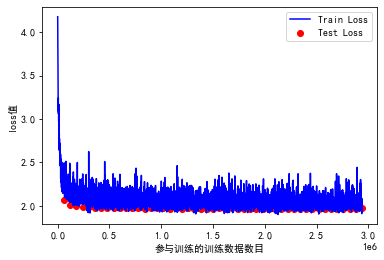

In [52]:
#继续训练代码块
con_net = Neuro_net()#初始化神经网络
if torch.cuda.is_available():
    net=net.cuda()
#optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate,momentum=momentum)#SGD优化器
con_optimizer=torch.optim.Adam(net.parameters(), lr=learning_rate,weight_decay =weightdecay)#ADAM优化器
#optimizer=torch.optim.RMSprop(net.parameters(), lr=learning_rate)#RMSprop优化器
#load训练过程中的模型与优化器，以便继续训练
net_dict = torch.load('model.pth')
con_net.load_state_dict(net_dict)
optimizer_dict = torch.load('optimizer.pth')
con_optimizer.load_state_dict(optimizer_dict)
#继续训练并绘图
for epoch in range(6, 50):#训练epoch轮
    train(epoch)
    test(epoch)
    
fig = plt.figure()#绘图
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('参与训练的训练数据数目')
plt.ylabel('loss值')

In [55]:
##预测代码块
con_net = Neuro_net()#初始化神经网络
if torch.cuda.is_available():
    net=net.cuda()
net_dict = torch.load('model.pth')
con_net.load_state_dict(net_dict)#加载模型数据
print("评估训练集应用模型结果")
pred(train_loader,con_net)
print("评估测试集应用模型结果")
pred(test_loader,con_net)

评估训练集应用模型结果
预测时间:4705.669599999965毫秒
当前模型的预测评估结果为：
              precision    recall  f1-score   support

           0     0.9953    0.9891    0.9922      5960
           1     0.9893    0.9951    0.9922      6703
           2     0.9891    0.9818    0.9855      6002
           3     0.9847    0.9923    0.9885      6084
           4     0.9878    0.9875    0.9877      5844
           5     0.9843    0.9894    0.9869      5393
           6     0.9936    0.9869    0.9902      5958
           7     0.9868    0.9847    0.9857      6278
           8     0.9824    0.9912    0.9868      5799
           9     0.9844    0.9794    0.9819      5979

    accuracy                         0.9878     60000
   macro avg     0.9878    0.9877    0.9877     60000
weighted avg     0.9878    0.9878    0.9878     60000

评估测试集应用模型结果
预测时间:789.8635000001377毫秒
当前模型的预测评估结果为：
              precision    recall  f1-score   support

           0     0.9949    0.9839    0.9893       991
           1     0.9965    0.9

In [56]:
#SVC模型对比模块
#根据第九次实验结果，使用高斯核效果较好，直接使用该次试验的参数
c=0.5#惩罚系数
pcanum=75
train_num=60000#选多少作为训练数据
print("使用PCA降维，降低维度至",pcanum)
pca=PCA(n_components=pcanum)#使用sklearn的pca降维工具
pca.fit(train_data)#训练pca
low_train_data=pca.transform(train_data)#对训练数据与测试数据进行降维处理
low_test_data=pca.transform(test_data)
shuffle_low_train_data,shuffle_low_label_data=Myshuffle(low_train_data,train_label,train_num)#取部分数据进行训练，这里取全部数据进行
clf=classify(c,typename='rbf')#定义一个高斯核的svm分类器
print("高斯核的评估如下")
svctrain(clf,shuffle_low_train_data,shuffle_low_label_data)#开始训练   
print_accuracy(clf,shuffle_low_train_data,shuffle_low_label_data,low_test_data,test_label)#使用该模型进行预测，并进行评估

使用PCA降维，降低维度至 75
(60000, 75) (60000,)
(60000, 75) (60000,)
高斯核的评估如下
训练时间:103909.63069999998毫秒
预测时间:265549.9626999999毫秒
训练集评估
60000 60000
              precision    recall  f1-score   support

         0.0     0.9929    0.9954    0.9942      5923
         1.0     0.9899    0.9929    0.9914      6742
         2.0     0.9858    0.9904    0.9881      5958
         3.0     0.9880    0.9796    0.9838      6131
         4.0     0.9818    0.9873    0.9846      5842
         5.0     0.9873    0.9860    0.9866      5421
         6.0     0.9921    0.9943    0.9932      5918
         7.0     0.9847    0.9845    0.9846      6265
         8.0     0.9878    0.9850    0.9864      5851
         9.0     0.9816    0.9763    0.9789      5949

    accuracy                         0.9872     60000
   macro avg     0.9872    0.9872    0.9872     60000
weighted avg     0.9872    0.9872    0.9872     60000

测试集评估
              precision    recall  f1-score   support

           0     0.9799    0.9929    0.9863

In [57]:
#使用决策树作为基学习器的b随机森林集成学习方法。
#
train_num=60000
rf = RandomForestClassifier(n_estimators=50,max_depth=5,n_jobs=-1, oob_score=True, random_state=10)#定义一个随机森林分类器
shuffle_rain_data,shuffle_label_data=Myshuffle(ss_train_data,train_label,train_num)#取部分数据进行训练
T1 = time.perf_counter()
model = rf.fit(shuffle_rain_data, shuffle_label_data)
T2 =time.perf_counter()
print('训练时间:%s毫秒' % ((T2 - T1)*1000))#记录训练时间与其他进行对比
print_accuracy(model,shuffle_rain_data,shuffle_label_data,ss_test_data,test_label)

(60000, 784) (60000,)
(60000, 784) (60000,)
训练时间:7417.10490000014毫秒
预测时间:712.4477000002116毫秒
训练集评估
60000 60000
              precision    recall  f1-score   support

         0.0     0.9140    0.9581    0.9355      5923
         1.0     0.8365    0.9800    0.9026      6742
         2.0     0.9108    0.8402    0.8741      5958
         3.0     0.7853    0.8336    0.8088      6131
         4.0     0.8779    0.8317    0.8542      5842
         5.0     0.9356    0.6781    0.7863      5421
         6.0     0.8910    0.9229    0.9067      5918
         7.0     0.8792    0.8961    0.8876      6265
         8.0     0.8453    0.7788    0.8107      5851
         9.0     0.7612    0.8341    0.7960      5949

    accuracy                         0.8588     60000
   macro avg     0.8637    0.8554    0.8562     60000
weighted avg     0.8625    0.8588    0.8575     60000

测试集评估
              precision    recall  f1-score   support

           0     0.9015    0.9806    0.9394       980
           1   

In [58]:
#使用决策树作为基学习期器的bagging的结果如下
train_num=60000#取部分数据进行训练
bgc=BaggingClassifier(n_estimators=50,bootstrap=True, n_jobs=-1, oob_score=True)#创建一个bgc
shuffle_rain_data,shuffle_label_data=Myshuffle(ss_train_data,train_label,train_num)#取部分数据进行训练，
T1 = time.perf_counter()
model = bgc.fit(shuffle_rain_data, shuffle_label_data)
T2 =time.perf_counter()
print('训练时间:%s毫秒' % ((T2 - T1)*1000))#记录训练时间与其他进行对比
print_accuracy(model,shuffle_rain_data,shuffle_label_data,ss_test_data,test_label)#进行评估

(60000, 784) (60000,)
(60000, 784) (60000,)
训练时间:275147.98740000016毫秒
预测时间:35462.636199999906毫秒
训练集评估
60000 60000
              precision    recall  f1-score   support

         0.0     0.9998    1.0000    0.9999      5923
         1.0     1.0000    1.0000    1.0000      6742
         2.0     1.0000    0.9998    0.9999      5958
         3.0     1.0000    1.0000    1.0000      6131
         4.0     1.0000    1.0000    1.0000      5842
         5.0     1.0000    1.0000    1.0000      5421
         6.0     1.0000    1.0000    1.0000      5918
         7.0     1.0000    1.0000    1.0000      6265
         8.0     1.0000    1.0000    1.0000      5851
         9.0     1.0000    1.0000    1.0000      5949

    accuracy                         1.0000     60000
   macro avg     1.0000    1.0000    1.0000     60000
weighted avg     1.0000    1.0000    1.0000     60000

测试集评估
              precision    recall  f1-score   support

           0     0.9584    0.9878    0.9729       980
           1